<a href="https://colab.research.google.com/github/HAQ-NAWAZ-MALIK/Projects-2025/blob/main/unstructured_HNM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# unstructured-io____________HNM


This notebook provides a complete end-to-end implementation for processing PDF and HTML documents using the Unstructured library.

1. **Installation**: Installs the Unstructured library and its dependencies for PDF and HTML processing, along with other required packages
2. **Imports**: Sets up all necessary libraries and downloads NLTK data
3. **Helper Functions**: Creates utility functions for visualization
4. **File Upload**: Allows uploading PDF and HTML files
5. **Partitioning**: Extracts structured elements from both document types
6. **Cleaning**: Processes text elements to remove extra whitespace and normalize formatting
7. **Extracting**: Enhances element metadata with additional information
8. **Staging**: Converts elements to structured formats (JSON and DataFrame)
9. **Chunking**: Groups elements into logical chunks based on document structure
10. **Embedding**: Generates vector embeddings for each chunk using a Sentence Transformer model
11. **Final Output**: Creates a comprehensive report with visualization of the processing results


This pipeline demonstrates how Unstructured can transform unstructured documents into structured data suitable for downstream NLP applications.

In [1]:
# Cell 1: Install required packages
!pip install unstructured "unstructured[pdf,html]" sentence-transformers nltk huggingface_hub matplotlib pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 901.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# Cell 2: Import necessary libraries
import os
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from google.colab import files

In [2]:
# Download required NLTK data
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# Import Unstructured components
from unstructured.partition.pdf import partition_pdf
from unstructured.partition.html import partition_html
from unstructured.cleaners.core import clean_extra_whitespace, replace_unicode_quotes
from unstructured.staging.base import elements_to_json
from unstructured.chunking.title import chunk_by_title
from sentence_transformers import SentenceTransformer


In [4]:
# Cell 3: Define helper functions for visualization
def display_elements(elements, title="Document Elements"):
    """Display elements in a readable format"""
    print(f"\n{title}\n{'=' * len(title)}")
    for i, element in enumerate(elements):
        print(f"Element {i+1}: {type(element).__name__}")
        print(f"Text: {element.text[:100]}..." if len(element.text) > 100 else f"Text: {element.text}")
        print(f"Metadata: {element.metadata}")
        print("-" * 50)

def visualize_embeddings(embeddings, labels):
    """Visualize embeddings using PCA"""
    from sklearn.decomposition import PCA

    # Apply PCA to reduce dimensions for visualization
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

    # Add labels
    for i, label in enumerate(labels):
        plt.annotate(f"Chunk {i+1}", (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

    plt.title("2D Visualization of Document Embeddings")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()


In [5]:
# Cell 4: Upload PDF and HTML documents
print("Please upload a PDF document")
pdf_file = files.upload()
pdf_filename = list(pdf_file.keys())[0]

print("\nPlease upload an HTML document")
html_file = files.upload()
html_filename = list(html_file.keys())[0]

print(f"\nUploaded files: {pdf_filename}, {html_filename}")



Please upload a PDF document


Saving DA-1p.pdf to DA-1p.pdf

Please upload an HTML document


Saving example_full_doc.html to example_full_doc.html

Uploaded files: DA-1p.pdf, example_full_doc.html


In [7]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 1s (272 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126209 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.6_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.6) ...
Setting up poppler-utils (22.02.0-2ubuntu0.6) ...
Processing triggers for man-db (2.10.2-1) ...


In [9]:
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,166 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 126239 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [10]:
# Cell 5: Step 1 - Partitioning (extract elements from documents)
print("\n1. PARTITIONING DOCUMENTS")
print("-" * 50)

# Partition PDF
pdf_elements = partition_pdf(
    pdf_filename,
    extract_images=True,
    infer_table_structure=True,
    chunking_strategy="by_title"
)
print(f"Extracted {len(pdf_elements)} elements from PDF")

# Partition HTML
html_elements = partition_html(
    filename=html_filename,
    extract_links=True
)
print(f"Extracted {len(html_elements)} elements from HTML")

# Show sample elements
display_elements(pdf_elements[:5], "Sample PDF Elements")
display_elements(html_elements[:5], "Sample HTML Elements")




1. PARTITIONING DOCUMENTS
--------------------------------------------------


config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Extracted 8 elements from PDF
Extracted 82 elements from HTML

Sample PDF Elements
Element 1: CompositeElement
Text: MAIN GAME

CREATURES

Abomination

"We arrived in the dead of night. We had been tracking the malefi...
Metadata: <unstructured.documents.elements.ElementMetadata object at 0x788a74b92010>
--------------------------------------------------
Element 2: CompositeElement
Text: There, perched atop the spire of the village chantry, stood the mage. But he was human no longer.
Metadata: <unstructured.documents.elements.ElementMetadata object at 0x788a74b90b50>
--------------------------------------------------
Element 3: CompositeElement
Text: We shouted prayers to the Maker and deflected what magic we could, but as we fought, the creature fo...
Metadata: <unstructured.documents.elements.ElementMetadata object at 0x788a74b92250>
--------------------------------------------------
Element 4: CompositeElement
Text: —Transcribed from a tale told by a former templar in Cumberland, 8:

In [11]:
# Cell 6: Step 2 - Cleaning
print("\n2. CLEANING ELEMENTS")
print("-" * 50)

# Apply cleaning functions
def clean_elements(elements):
    cleaned_elements = []
    for element in elements:
        # Skip non-text elements
        if not hasattr(element, 'text'):
            cleaned_elements.append(element)
            continue

        # Apply cleaning operations
        cleaned_text = element.text
        cleaned_text = clean_extra_whitespace(cleaned_text)
        cleaned_text = replace_unicode_quotes(cleaned_text)

        # Update the element's text
        element.text = cleaned_text
        cleaned_elements.append(element)

    return cleaned_elements

pdf_elements_cleaned = clean_elements(pdf_elements)
html_elements_cleaned = clean_elements(html_elements)

print(f"Cleaned {len(pdf_elements_cleaned)} PDF elements")
print(f"Cleaned {len(html_elements_cleaned)} HTML elements")

# Show sample cleaned elements
display_elements(pdf_elements_cleaned[:3], "Sample Cleaned PDF Elements")
display_elements(html_elements_cleaned[:3], "Sample Cleaned HTML Elements")




2. CLEANING ELEMENTS
--------------------------------------------------
Cleaned 8 PDF elements
Cleaned 82 HTML elements

Sample Cleaned PDF Elements
Element 1: CompositeElement
Text: MAIN GAME CREATURES Abomination "We arrived in the dead of night. We had been tracking the maleficar...
Metadata: <unstructured.documents.elements.ElementMetadata object at 0x788a74b92010>
--------------------------------------------------
Element 2: CompositeElement
Text: There, perched atop the spire of the village chantry, stood the mage. But he was human no longer.
Metadata: <unstructured.documents.elements.ElementMetadata object at 0x788a74b90b50>
--------------------------------------------------
Element 3: CompositeElement
Text: We shouted prayers to the Maker and deflected what magic we could, but as we fought, the creature fo...
Metadata: <unstructured.documents.elements.ElementMetadata object at 0x788a74b92250>
--------------------------------------------------

Sample Cleaned HTML Elements
Elem

In [13]:
# Cell 7: Step 3 - Extracting (metadata and structured information)
print("\n3. EXTRACTING METADATA AND STRUCTURED INFORMATION")
print("-" * 50)

# Extract additional metadata from elements
from unstructured.documents.elements import ElementMetadata
def enhance_metadata(elements, source_type):
    for i, element in enumerate(elements):
        # Create an ElementMetadata instance if it doesn't exist
        if not hasattr(element, 'metadata') or not isinstance(element.metadata, ElementMetadata):
            element.metadata = ElementMetadata()

        # Update metadata using setattr to avoid the ValueError
        element.metadata.source_type = source_type
        element.metadata.element_id = f"{source_type}_{i+1}"
        element.metadata.element_type = type(element).__name__

    return elements

pdf_elements_extracted = enhance_metadata(pdf_elements_cleaned, "pdf")
html_elements_extracted = enhance_metadata(html_elements_cleaned, "html")

# Display enhanced elements
display_elements(pdf_elements_extracted[:3], "PDF Elements with Enhanced Metadata")
display_elements(html_elements_extracted[:3], "HTML Elements with Enhanced Metadata")


3. EXTRACTING METADATA AND STRUCTURED INFORMATION
--------------------------------------------------

PDF Elements with Enhanced Metadata
Element 1: CompositeElement
Text: MAIN GAME CREATURES Abomination "We arrived in the dead of night. We had been tracking the maleficar...
Metadata: <unstructured.documents.elements.ElementMetadata object at 0x788a74b92010>
--------------------------------------------------
Element 2: CompositeElement
Text: There, perched atop the spire of the village chantry, stood the mage. But he was human no longer.
Metadata: <unstructured.documents.elements.ElementMetadata object at 0x788a74b90b50>
--------------------------------------------------
Element 3: CompositeElement
Text: We shouted prayers to the Maker and deflected what magic we could, but as we fought, the creature fo...
Metadata: <unstructured.documents.elements.ElementMetadata object at 0x788a74b92250>
--------------------------------------------------

HTML Elements with Enhanced Metadata
Element

In [14]:
# Cell 8: Step 4 - Staging (convert to structured format)
print("\n4. STAGING (CONVERTING TO STRUCTURED FORMAT)")
print("-" * 50)

# Convert elements to JSON
pdf_json = elements_to_json(pdf_elements_extracted)
html_json = elements_to_json(html_elements_extracted)

# Display sample of JSON output
print("\nSample PDF JSON:")
print(pdf_json[:1])
print("\nSample HTML JSON:")
print(html_json[:1])

# Create DataFrame representation
def elements_to_dataframe(elements):
    data = []
    for element in elements:
        if hasattr(element, 'text'):
            row = {
                'element_type': type(element).__name__,
                'text': element.text[:100] + "..." if len(element.text) > 100 else element.text,
                'metadata': str(element.metadata)
            }
            data.append(row)
    return pd.DataFrame(data)

pdf_df = elements_to_dataframe(pdf_elements_extracted)
html_df = elements_to_dataframe(html_elements_extracted)

print("\nPDF Elements DataFrame:")
display(pdf_df.head(3))

print("\nHTML Elements DataFrame:")
display(html_df.head(3))



4. STAGING (CONVERTING TO STRUCTURED FORMAT)
--------------------------------------------------

Sample PDF JSON:
[

Sample HTML JSON:
[

PDF Elements DataFrame:


,element_type,text,metadata
0,CompositeElement,"MAIN GAME CREATURES Abomination ""We arrived in...",<unstructured.documents.elements.ElementMetada...
1,CompositeElement,"There, perched atop the spire of the village c...",<unstructured.documents.elements.ElementMetada...
2,CompositeElement,We shouted prayers to the Maker and deflected ...,<unstructured.documents.elements.ElementMetada...



HTML Elements DataFrame:


,element_type,text,metadata
0,Text,"Table of Contents 11/7/23, 2:38 PM https://www...",<unstructured.documents.elements.ElementMetada...
1,Title,ENTERPRISE PRODUCTS PARTNERS L.P.,<unstructured.documents.elements.ElementMetada...
2,Title,NOTES TO UNAUDITED CONDENSED CONSOLIDATED FINA...,<unstructured.documents.elements.ElementMetada...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [16]:
# Cell 9: Step 5 - Chunking
print("\n5. CHUNKING ELEMENTS")
print("-" * 50)

# Combine all elements for chunking
all_elements = pdf_elements_extracted + html_elements_extracted

# Chunk by title
chunked_elements = chunk_by_title(all_elements)
print(f"Created {len(chunked_elements)} chunks from {len(all_elements)} elements")

# Display chunks
for i, chunk in enumerate(chunked_elements[:3]):
    print(f"\nChunk {i+1}")
    # Access the length of the CompositeElement directly (assuming it represents a single element)
    print(f"Number of elements: 1")
    print(f"First few elements: {[type(chunk).__name__]}")
    # Check if the chunk has a 'text' attribute before accessing it
    if hasattr(chunk, 'text'):
        chunk_text = chunk.text
    else:
        chunk_text = ""
    print(f"Sample text: {chunk_text[:200]}...")
    print("-" * 50)

# Create chunks dataframe
chunks_df = pd.DataFrame({
    'chunk_id': [f"chunk_{i+1}" for i in range(len(chunked_elements))],
    # All chunks assumed to have 1 element
    'num_elements': [1] * len(chunked_elements),
    'preview': [chunk.text[:100] + "..." if hasattr(chunk, 'text') else ""
               for chunk in chunked_elements]
})

print("\nChunks DataFrame:")
display(chunks_df)


5. CHUNKING ELEMENTS
--------------------------------------------------
Created 61 chunks from 90 elements

Chunk 1
Number of elements: 1
First few elements: ['CompositeElement']
Sample text: MAIN GAME CREATURES Abomination "We arrived in the dead of night. We had been tracking the maleficar for days, and finally had him cornered... or so we thought. As we approached, a home on the edge of...
--------------------------------------------------

Chunk 2
Number of elements: 1
First few elements: ['CompositeElement']
Sample text: There, perched atop the spire of the village chantry, stood the mage. But he was human no longer....
--------------------------------------------------

Chunk 3
Number of elements: 1
First few elements: ['CompositeElement']
Sample text: We shouted prayers to the Maker and deflected what magic we could, but as we fought, the creature fought harder. I saw my comrades fall, burned by the flaming sky or crushed by debris. The monstrous c...
--------------------------

,chunk_id,num_elements,preview
0,chunk_1,1,"MAIN GAME CREATURES Abomination ""We arrived in..."
1,chunk_2,1,"There, perched atop the spire of the village c..."
2,chunk_3,1,We shouted prayers to the Maker and deflected ...
3,chunk_4,1,—Transcribed from a tale told by a former temp...
4,chunk_5,1,"Regardless of the reason, a demon always attem..."
...,...,...,...
56,chunk_57,1,"Common units outstanding at December 31, 2022 ..."
57,chunk_58,1,Registration Statements\n\nWe have a universal...
58,chunk_59,1,"In addition, the Partnership has a registratio..."
59,chunk_60,1,ATM program remains at $2.5 billion as of June...



6. GENERATING EMBEDDINGS
--------------------------------------------------
Loaded embedding model: all-MiniLM-L6-v2
Generated embeddings with shape: (61, 384)


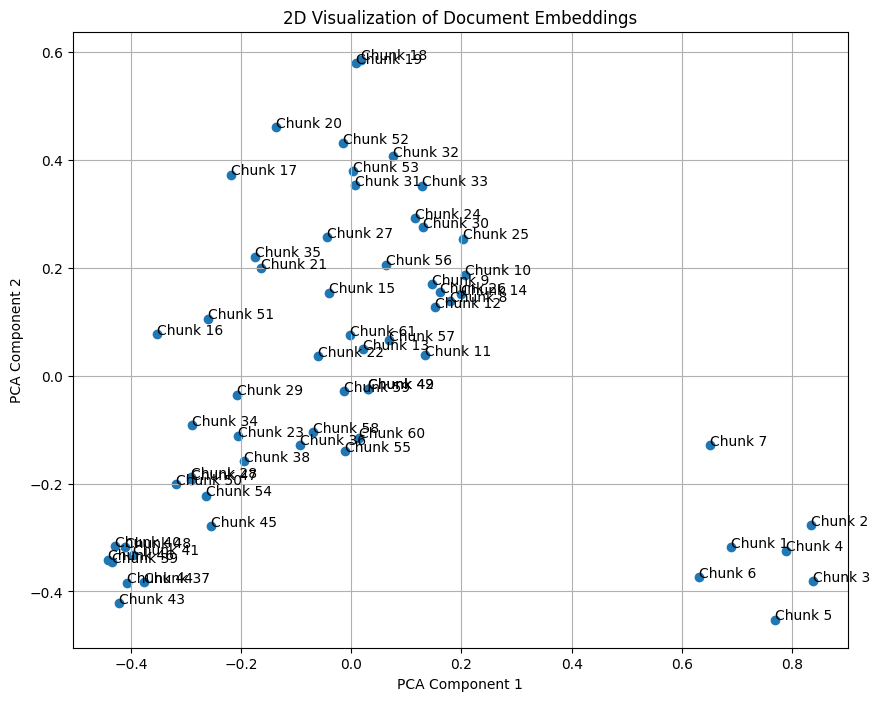

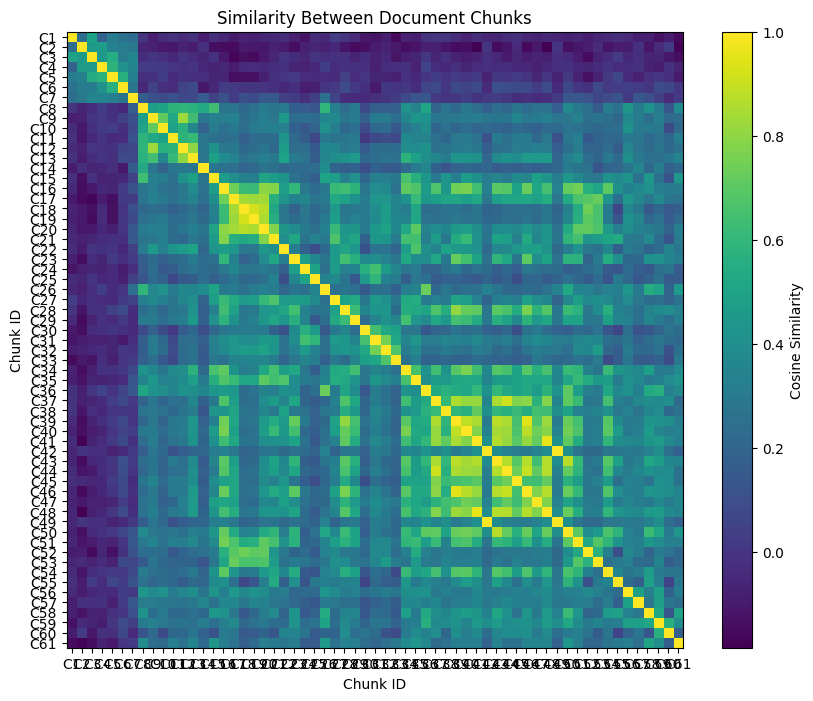

In [18]:
# Cell 10: Step 6 - Embedding
print("\n6. GENERATING EMBEDDINGS")
print("-" * 50)

# Load sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"Loaded embedding model: all-MiniLM-L6-v2")

# Generate text for embedding
chunk_texts = []
for chunk in chunked_elements:
    # Check if the chunk has a 'text' attribute before accessing it
    if hasattr(chunk, 'text'):
        chunk_text = chunk.text
    else:
        chunk_text = ""  # Or some default value
    chunk_texts.append(chunk_text)

# Generate embeddings
embeddings = model.encode(chunk_texts)
print(f"Generated embeddings with shape: {embeddings.shape}")

# Visualize embeddings
visualize_embeddings(embeddings, [f"Chunk {i+1}" for i in range(len(chunk_texts))])

# Calculate and display cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(embeddings)

plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.title('Similarity Between Document Chunks')
plt.xlabel('Chunk ID')
plt.ylabel('Chunk ID')
plt.xticks(np.arange(len(chunked_elements)), [f'C{i+1}' for i in range(len(chunked_elements))])
plt.yticks(np.arange(len(chunked_elements)), [f'C{i+1}' for i in range(len(chunked_elements))])
plt.show()

In [21]:
# Cell 11: Final Output - Create a comprehensive document processing report
print("\n7. FINAL REPORT AND VISUALIZATION")
print("-" * 50)

# Store embeddings and metadata in a structured format
final_data = []
for i, (chunk, embedding) in enumerate(zip(chunked_elements, embeddings)):
    # Access the text directly from the CompositeElement if it has a 'text' attribute
    if hasattr(chunk, 'text'):
        chunk_text = chunk.text
    else:
        chunk_text = ""  # or some other default value

    # Assuming each chunk is a single element:
    metadata = {
        'chunk_id': f"chunk_{i+1}",
        # Update: Access metadata directly from the chunk if available
        # Directly access 'source_type' using getattr to handle potential absence
        'sources': [getattr(chunk.metadata, 'source_type', 'unknown')] if hasattr(chunk, 'metadata') else ['unknown'],
        'num_elements': 1,  # Update: Assume 1 element per chunk
        'embedding_dim': embedding.shape[0],
        'text_length': len(chunk_text)
    }

    final_data.append({
        'chunk_id': f"chunk_{i+1}",
        'metadata': metadata,
        'text': chunk_text[:200] + "..." if len(chunk_text) > 200 else chunk_text,
        'embedding': embedding
    })
# Create final dataframe (without embeddings for display)
final_df = pd.DataFrame([
    {
        'chunk_id': d['chunk_id'],
        'sources': ", ".join(d['metadata']['sources']),
        'num_elements': d['metadata']['num_elements'],
        'text_length': d['metadata']['text_length'],
        'preview': d['text']
    } for d in final_data
])

print("\nFinal Processed Document Chunks:")
display(final_df)




# Create simple HTML visualizer
html_output = """
<html>
<head>
    <style>
        body { font-family: Arial, sans-serif; margin: 20px; }
        .container { max-width: 1000px; margin: 0 auto; }
        .chunk { border: 1px solid #ccc; margin-bottom: 20px; padding: 15px; border-radius: 5px; }
        .chunk-header { display: flex; justify-content: space-between; margin-bottom: 10px; }
        .chunk-id { font-weight: bold; font-size: 18px; }
        .chunk-metadata { color: #666; }
        .chunk-text { font-size: 14px; line-height: 1.5; }
        .pdf-source { background-color: #ffeeee; }
        .html-source { background-color: #eeeeff; }
        .mixed-source { background-color: #eeffee; }
    </style>
</head>
<body>
    <div class="container">
        <h1>Document Processing Results</h1>
        <p>Processed document chunks with embeddings from PDF and HTML sources</p>
        <div class="chunks">
"""

for data in final_data:
    source_class = ""
    if "pdf" in data['metadata']['sources'] and "html" in data['metadata']['sources']:
        source_class = "mixed-source"
    elif "pdf" in data['metadata']['sources']:
        source_class = "pdf-source"
    elif "html" in data['metadata']['sources']:
        source_class = "html-source"

    html_output += f"""
        <div class="chunk {source_class}">
            <div class="chunk-header">
                <div class="chunk-id">{data['chunk_id']}</div>
                <div class="chunk-metadata">
                    Source: {', '.join(data['metadata']['sources'])} |
                    Elements: {data['metadata']['num_elements']} |
                    Text Length: {data['metadata']['text_length']}
                </div>
            </div>
            <div class="chunk-text">{data['text']}</div>
        </div>
    """

html_output += """
        </div>
    </div>
</body>
</html>
"""

# Display the HTML visualization
display(HTML(html_output))

print("\nProcessing Pipeline Complete!")
print("""
Summary of Steps:
1. Partitioning: Extracted elements from PDF and HTML documents
2. Cleaning: Applied text cleaning operations
3. Extracting: Enhanced metadata for each element
4. Staging: Converted to structured formats (JSON and DataFrame)
5. Chunking: Grouped elements into logical chunks
6. Embedding: Generated vector embeddings for each chunk
7. Final Output: Created structured data repository of processed documents
""")

# Save final output to file
with open('processed_document_data.json', 'w') as f:
    import json
    json.dump([{
        'chunk_id': d['chunk_id'],
        'metadata': d['metadata'],
        'text': d['text'],
        # Convert numpy array to list for JSON serialization
        'embedding': d['embedding'].tolist()
    } for d in final_data], f)

print("\nSaved processed document data to 'processed_document_data.json'")
print("You can now use this processed data for downstream applications such as:")
print("- Semantic search")
print("- Document comparison")
print("- Question answering")
print("- Knowledge base construction")


7. FINAL REPORT AND VISUALIZATION
--------------------------------------------------

Final Processed Document Chunks:


,chunk_id,sources,num_elements,text_length,preview
0,chunk_1,unknown,1,443,"MAIN GAME CREATURES Abomination ""We arrived in..."
1,chunk_2,unknown,1,97,"There, perched atop the spire of the village c..."
2,chunk_3,unknown,1,426,We shouted prayers to the Maker and deflected ...
3,chunk_4,unknown,1,424,—Transcribed from a tale told by a former temp...
4,chunk_5,unknown,1,499,"Regardless of the reason, a demon always attem..."
...,...,...,...,...,...
56,chunk_57,html,1,471,"Common units outstanding at December 31, 2022 ..."
57,chunk_58,unknown,1,234,Registration Statements\n\nWe have a universal...
58,chunk_59,unknown,1,500,"In addition, the Partnership has a registratio..."
59,chunk_60,unknown,1,56,ATM program remains at $2.5 billion as of June...



Processing Pipeline Complete!

Summary of Steps:
1. Partitioning: Extracted elements from PDF and HTML documents
2. Cleaning: Applied text cleaning operations
3. Extracting: Enhanced metadata for each element
4. Staging: Converted to structured formats (JSON and DataFrame)
5. Chunking: Grouped elements into logical chunks
6. Embedding: Generated vector embeddings for each chunk
7. Final Output: Created structured data repository of processed documents


Saved processed document data to 'processed_document_data.json'
You can now use this processed data for downstream applications such as:
- Semantic search
- Document comparison
- Question answering
- Knowledge base construction


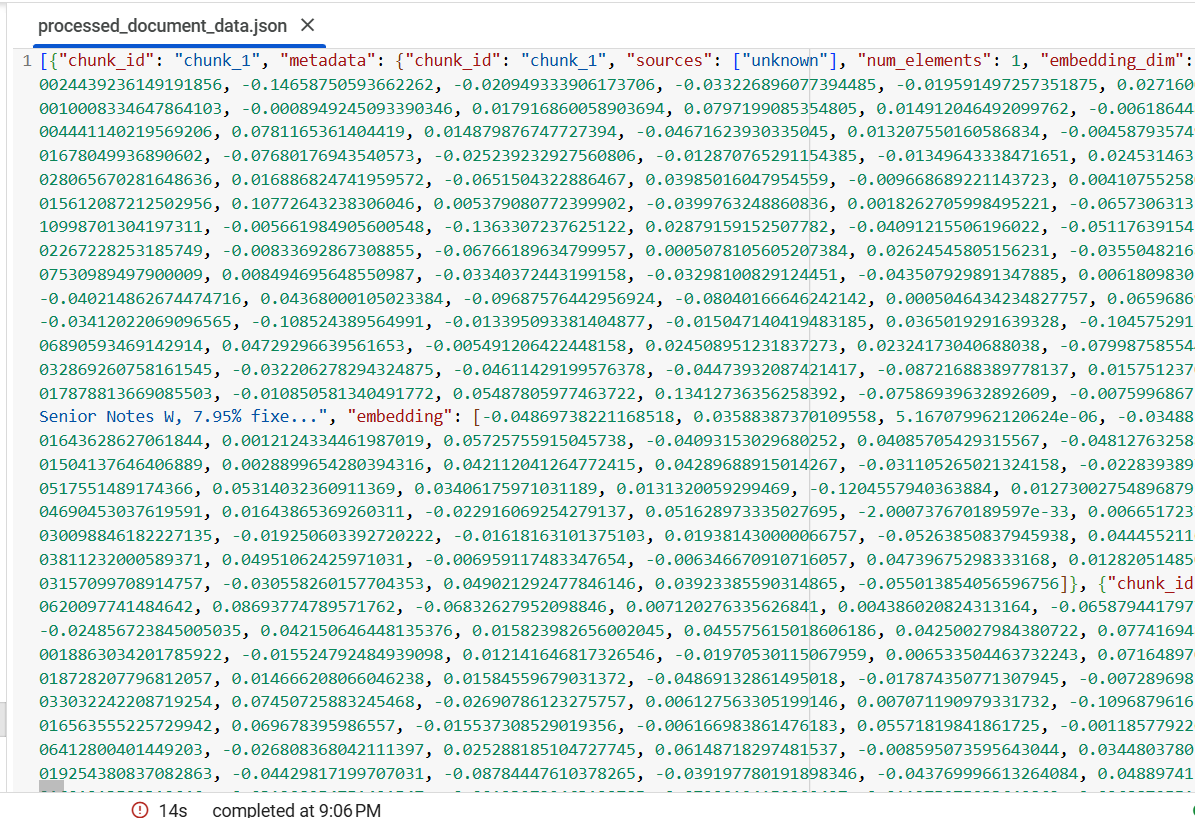

Saved processed document data to 'processed_document_data.json'
You can now use this processed data for downstream applications such as:
- Semantic search
- Document comparison
- Question answering
- Knowledge base constructi